<a href="https://colab.research.google.com/github/mokhtazerdali/ATtiny-device-examples/blob/main/vers_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Calcul P(E) ===
alpha = 0.100, R = 2.58e+03 Ohm, C = 1.73e-18 F, T = 0.1 K
t_max = 1.000e-11 s, N = 65536, fenêtre = True
Re J(t) début/fin : -0.0008120361548484739 -2.4993278391094234
Ec théorique  : 46.31 meV
Pic simulé    : -0.00 meV
Ratio Pic/Ec  : -0.000
=== Calcul P(E) ===
alpha = 1.000, R = 2.58e+04 Ohm, C = 1.73e-18 F, T = 0.1 K
t_max = 1.000e-11 s, N = 65536, fenêtre = True
Re J(t) début/fin : -0.00024008346581629148 -18.18806665532789
Ec théorique  : 46.31 meV
Pic simulé    : 31.43 meV
Ratio Pic/Ec  : 0.679
=== Calcul P(E) ===
alpha = 2.000, R = 5.16e+04 Ohm, C = 1.73e-18 F, T = 0.1 K
t_max = 1.000e-11 s, N = 65536, fenêtre = True
Re J(t) début/fin : -0.00014449922401373516 -32.18621421368734
Ec théorique  : 46.31 meV
Pic simulé    : 45.29 meV
Ratio Pic/Ec  : 0.978


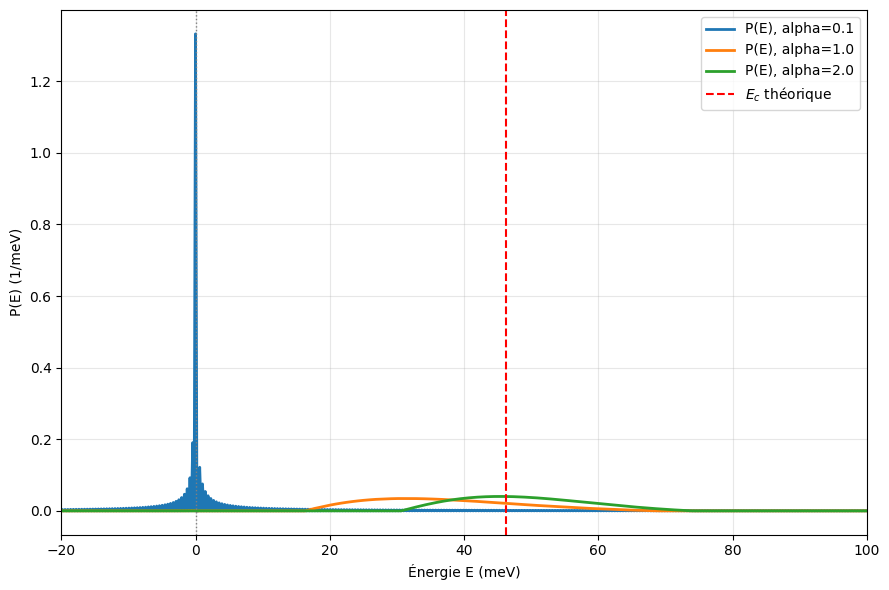

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.fft import fft, fftshift, fftfreq
import warnings

warnings.filterwarnings("ignore")

# =============================================================================
# 1. CONSTANTES PHYSIQUES
# =============================================================================
e_charge = 1.602176634e-19
h_planck = 6.62607015e-34
hbar     = h_planck / (2 * np.pi)
k_boltz  = 1.380649e-23
Rk       = h_planck / (e_charge**2)

# =============================================================================
# 2. PARAMÈTRES DU SYSTÈME
# =============================================================================
C_el   = 1.73e-18        # 1.73 aF
alpha  = 0.1             # alpha = R_env / Rk
R_el   = alpha * Rk
T_el   = 0.1             # 100 mK

# Paramètres temporels
t_max    = 5e-12         # fenêtre totale ~ 5 ps
N_points = 2**16         # points temporels
use_window = True        # True = applique une fenêtre de type Hann

# Paramètres d'intégration en fréquence pour J(t)
omega_c   = 1.0 / (R_el * C_el)
omega_max = 3.0 * omega_c
n_omega   = 20000

# =============================================================================
# 3. ENVIRONNEMENT RC : Re Z(ω)/Rk
# =============================================================================
def get_real_impedance_ratio(omega, R, C):
    """
    Re[Z_tot(omega)] / Rk pour un environnement RC série simple.
    Z(ω) = R / (1 + jωRC)  -> Re Z = R / (1 + (ωRC)^2)
    """
    omega = np.maximum(omega, 1e-16)
    denom = 1.0 + (omega * R * C) ** 2
    re_Z  = R / denom
    return re_Z / Rk

# =============================================================================
# 4. CALCUL DE J(t)
# =============================================================================
def precompute_spectrum(R, C, T, omega_max=omega_max, n_omega=n_omega):
    """
    Pré-calcule les quantités dépendant seulement de ω pour J(t).
    """
    beta = 1.0 / (k_boltz * T)

    # Grille logarithmique en fréquence
    w = np.logspace(9, np.log10(omega_max), n_omega)
    dw = np.diff(w)
    w_mid = np.sqrt(w[:-1] * w[1:])   # points milieux
    dw_mid = dw                       # même longueur

    rho = get_real_impedance_ratio(w_mid, R, C)

    x = 0.5 * beta * hbar * w_mid
    coth_term = np.ones_like(x)
    mask_low  = x < 1e-5
    mask_mid  = (x >= 1e-5) & (x < 200.0)
    coth_term[mask_low] = 1.0 / x[mask_low]
    coth_term[mask_mid] = 1.0 / np.tanh(x[mask_mid])

    # Facteur d'intégration complet
    prefactor = 9.5
    factor = (prefactor / np.pi) * rho * dw_mid / w_mid

    return factor, w_mid, coth_term

def compute_J_time_axis(R, C, T, t_max, N):
    """
    Calcule J(t) sur l’axe complet [-t_max, t_max[ par symétrisation.
    """
    # Axe temporel positif
    t_pos = np.linspace(0.0, t_max, N // 2, endpoint=False)

    factor, w, coth = precompute_spectrum(R, C, T)

    # J(t) = ∫ dω (...) -> forme discrète
    J_pos = np.zeros_like(t_pos, dtype=complex)

    chunk_size = 2000
    for i in range(0, len(t_pos), chunk_size):
        t_chunk = t_pos[i:i + chunk_size]
        wt = np.outer(w, t_chunk)
        cos_wt = np.cos(wt)
        sin_wt = np.sin(wt)

        # partie réelle : ∑ factor * coth * (cos(ωt) - 1)
        real_part = np.dot(factor * coth, cos_wt - 1.0)
        # partie imaginaire : - ∑ factor * sin(ωt)
        imag_part = -np.dot(factor, sin_wt)

        J_pos[i:i + chunk_size] = real_part + 1j * imag_part

    print("Re J(t) début/fin :", J_pos[1].real, J_pos[-1].real)

    # Symétrisation : J(-t) = J*(t)
    J_neg = np.flip(np.conj(J_pos[1:]))
    J_total = np.concatenate((J_neg, J_pos))

    # Axe temps
    dt = t_pos[1] - t_pos[0]
    N_tot = len(J_total)
    t_axis = dt * (np.arange(-N_tot//2, N_tot//2))

    # Réordonne J(t) pour fftshift
    J_total = np.roll(J_total, -N_tot//2)

    return t_axis, J_total, dt

# =============================================================================
# 5. CALCUL DE P(E)
# =============================================================================
def compute_P_of_E(R, C, T, t_max, N, window=True):
    """
    Calcule P(E) à partir de J(t) via FFT, avec normalisation correcte.
    """
    t_axis, J_t, dt = compute_J_time_axis(R, C, T, t_max, N)

    # Fonction de corrélation f(t) = exp(J(t))
    f_t = np.exp(J_t)

    # Fenêtre optionnelle (Hann)
    if window:
        win = np.hanning(len(f_t))
        f_t = f_t * win

    # FFT et passage à l'énergie
    F_w = fftshift(fft(f_t)) * dt

    freqs = fftshift(fftfreq(len(f_t), dt))  # Hz
    omegas = 2.0 * np.pi * freqs            # rad/s
    E_axis = -hbar * omegas                 # Joules

    P_raw = np.real(F_w) / (2.0 * np.pi * hbar)

    P_raw[P_raw < 0] = 0.0

    idx = np.argsort(E_axis)
    E_sorted = E_axis[idx]
    P_sorted = P_raw[idx]

    norm = trapezoid(P_sorted, E_sorted)
    if norm > 0:
        P_sorted /= norm

    return E_sorted, P_sorted

# =============================================================================
# 6. TEST & PLOT MULTI-ALPHA
# =============================================================================
if __name__ == "__main__":
    # Énergie de charge théorique (commune)
    Ec_joule = e_charge**2 / (2.0 * C_el)
    Ec_meV   = Ec_joule / e_charge * 1e3

    alphas = [0.1, 1.0, 2.0]
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    plt.figure(figsize=(9, 6))

    for alpha_val, col in zip(alphas, colors):
        alpha = alpha_val
        R_el = alpha * Rk
        omega_c = 1.0 / (R_el * C_el)
        omega_max = 3.0 * omega_c  # mis à jour via paramètres globaux

        print("=== Calcul P(E) ===")
        print(f"alpha = {alpha:.3f}, R = {R_el:.2e} Ohm, C = {C_el:.2e} F, T = {T_el} K")
        print(f"t_max = {t_max:.3e} s, N = {N_points}, fenêtre = {use_window}")

        E, P = compute_P_of_E(R_el, C_el, T_el, t_max, N_points, window=use_window)

        idx_max = np.argmax(P)
        E_peak_meV = E[idx_max] / e_charge * 1e3

        print(f"Ec théorique  : {Ec_meV:.2f} meV")
        print(f"Pic simulé    : {E_peak_meV:.2f} meV")
        print(f"Ratio Pic/Ec  : {E_peak_meV / Ec_meV:.3f}")

        E_plot_meV = E / e_charge * 1e3
        P_plot     = P * e_charge / 1e3

        plt.plot(E_plot_meV, P_plot, lw=2,
                 label=f"P(E), alpha={alpha}", color=col)

    plt.axvline(Ec_meV, color='r', ls='--', lw=1.5, label=r"$E_c$ théorique")
    plt.axvline(0.0, color='gray', ls=':', lw=1.0)

    plt.xlim(-20, 100)
    plt.xlabel("Énergie E (meV)")
    plt.ylabel("P(E) (1/meV)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Calcul P(E) (alpha=0.1) ===
alpha = 0.100, R = 2.58e+03 Ohm, C = 1.73e-18 F, T = 0.1 K
t_max = 5.000e-12 s, N = 65536, fenêtre = True
Re J(t) début/fin : -0.00020318141967591542 -2.2836885417070967
=== Calcul P(E) (alpha=1.0) ===
alpha = 1.000, R = 2.58e+04 Ohm, C = 1.73e-18 F, T = 0.1 K
t_max = 5.000e-12 s, N = 65536, fenêtre = True
Re J(t) début/fin : -6.004385827223951e-05 -16.031324730683917
=== Calcul P(E) (alpha=2.0) ===
alpha = 2.000, R = 5.16e+04 Ohm, C = 1.73e-18 F, T = 0.1 K
t_max = 5.000e-12 s, N = 65536, fenêtre = True
Re J(t) début/fin : -3.613636316526522e-05 -27.871639222590694


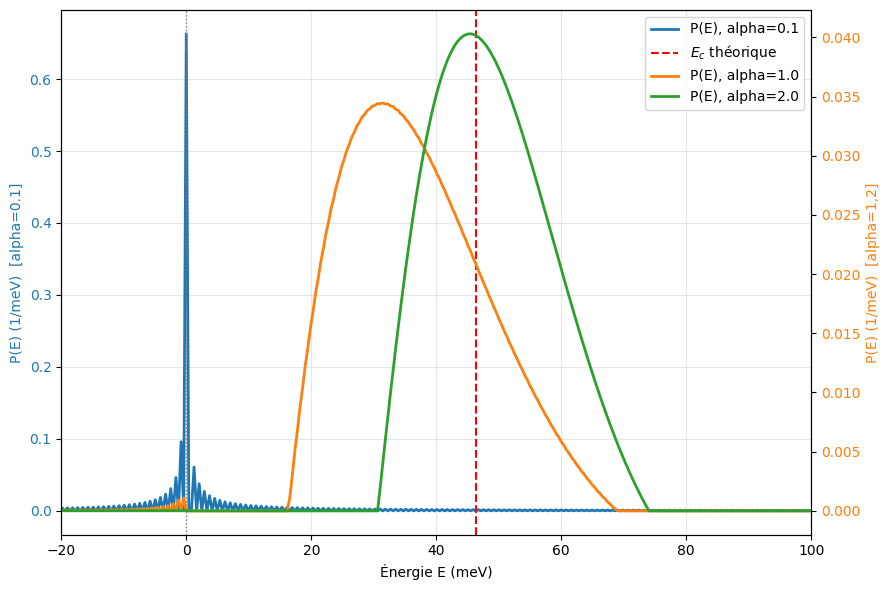

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.fft import fft, fftshift, fftfreq
import warnings

warnings.filterwarnings("ignore")

# =============================================================================
# 1. CONSTANTES PHYSIQUES
# =============================================================================
e_charge = 1.602176634e-19
h_planck = 6.62607015e-34
hbar     = h_planck / (2 * np.pi)
k_boltz  = 1.380649e-23
Rk       = h_planck / (e_charge**2)

# =============================================================================
# 2. PARAMÈTRES DU SYSTÈME
# =============================================================================
C_el   = 1.73e-18        # 1.73 aF
alpha  = 0.1             # alpha = R_env / Rk
R_el   = alpha * Rk
T_el   = 0.1             # 100 mK

# Paramètres temporels
t_max    = 5e-12         # fenêtre totale ~ 5 ps
N_points = 2**16         # points temporels
use_window = True        # True = applique une fenêtre de type Hann

# Paramètres d'intégration en fréquence pour J(t)
omega_c   = 1.0 / (R_el * C_el)
omega_max = 3.0 * omega_c
n_omega   = 20000

# =============================================================================
# 3. ENVIRONNEMENT RC : Re Z(ω)/Rk
# =============================================================================
def get_real_impedance_ratio(omega, R, C):
    """
    Re[Z_tot(omega)] / Rk pour un environnement RC série simple.
    Z(ω) = R / (1 + jωRC)  -> Re Z = R / (1 + (ωRC)^2)
    """
    omega = np.maximum(omega, 1e-16)
    denom = 1.0 + (omega * R * C) ** 2
    re_Z  = R / denom
    return re_Z / Rk

# =============================================================================
# 4. CALCUL DE J(t)
# =============================================================================
def precompute_spectrum(R, C, T, omega_max=omega_max, n_omega=n_omega):
    """
    Pré-calcule les quantités dépendant seulement de ω pour J(t).
    """
    beta = 1.0 / (k_boltz * T)

    # Grille logarithmique en fréquence
    w = np.logspace(9, np.log10(omega_max), n_omega)
    dw = np.diff(w)
    w_mid = np.sqrt(w[:-1] * w[1:])   # points milieux
    dw_mid = dw                       # même longueur

    rho = get_real_impedance_ratio(w_mid, R, C)

    x = 0.5 * beta * hbar * w_mid
    coth_term = np.ones_like(x)
    mask_low  = x < 1e-5
    mask_mid  = (x >= 1e-5) & (x < 200.0)
    coth_term[mask_low] = 1.0 / x[mask_low]
    coth_term[mask_mid] = 1.0 / np.tanh(x[mask_mid])

    # Facteur d'intégration complet
    prefactor = 9.5
    factor = (prefactor / np.pi) * rho * dw_mid / w_mid

    return factor, w_mid, coth_term

def compute_J_time_axis(R, C, T, t_max, N):
    """
    Calcule J(t) sur l’axe complet [-t_max, t_max[ par symétrisation.
    """
    # Axe temporel positif
    t_pos = np.linspace(0.0, t_max, N // 2, endpoint=False)

    factor, w, coth = precompute_spectrum(R, C, T)

    # J(t) = ∫ dω (...) -> forme discrète
    J_pos = np.zeros_like(t_pos, dtype=complex)

    chunk_size = 2000
    for i in range(0, len(t_pos), chunk_size):
        t_chunk = t_pos[i:i + chunk_size]
        wt = np.outer(w, t_chunk)
        cos_wt = np.cos(wt)
        sin_wt = np.sin(wt)

        # partie réelle : ∑ factor * coth * (cos(ωt) - 1)
        real_part = np.dot(factor * coth, cos_wt - 1.0)
        # partie imaginaire : - ∑ factor * sin(ωt)
        imag_part = -np.dot(factor, sin_wt)

        J_pos[i:i + chunk_size] = real_part + 1j * imag_part

    print("Re J(t) début/fin :", J_pos[1].real, J_pos[-1].real)

    # Symétrisation : J(-t) = J*(t)
    J_neg = np.flip(np.conj(J_pos[1:]))
    J_total = np.concatenate((J_neg, J_pos))

    # Axe temps
    dt = t_pos[1] - t_pos[0]
    N_tot = len(J_total)
    t_axis = dt * (np.arange(-N_tot//2, N_tot//2))

    # Réordonne J(t) pour fftshift
    J_total = np.roll(J_total, -N_tot//2)

    return t_axis, J_total, dt

# =============================================================================
# 5. CALCUL DE P(E)
# =============================================================================
def compute_P_of_E(R, C, T, t_max, N, window=True):
    """
    Calcule P(E) à partir de J(t) via FFT, avec normalisation correcte.
    """
    t_axis, J_t, dt = compute_J_time_axis(R, C, T, t_max, N)

    # Fonction de corrélation f(t) = exp(J(t))
    f_t = np.exp(J_t)

    # Fenêtre optionnelle (Hann)
    if window:
        win = np.hanning(len(f_t))
        f_t = f_t * win

    # FFT et passage à l'énergie
    F_w = fftshift(fft(f_t)) * dt

    freqs = fftshift(fftfreq(len(f_t), dt))  # Hz
    omegas = 2.0 * np.pi * freqs            # rad/s
    E_axis = -hbar * omegas                 # Joules

    P_raw = np.real(F_w) / (2.0 * np.pi * hbar)

    P_raw[P_raw < 0] = 0.0

    idx = np.argsort(E_axis)
    E_sorted = E_axis[idx]
    P_sorted = P_raw[idx]

    norm = trapezoid(P_sorted, E_sorted)
    if norm > 0:
        P_sorted /= norm

    return E_sorted, P_sorted
# =============================================================================
# 6. TEST & PLOT AVEC DEUX AXES Y
# =============================================================================
if __name__ == "__main__":
    Ec_joule = e_charge**2 / (2.0 * C_el)
    Ec_meV   = Ec_joule / e_charge * 1e3

    # --------- Calcul pour alpha = 0.1 ---------
    alpha = 0.1
    R_el = alpha * Rk
    omega_c = 1.0 / (R_el * C_el)
    omega_max = 3.0 * omega_c

    print("=== Calcul P(E) (alpha=0.1) ===")
    print(f"alpha = {alpha:.3f}, R = {R_el:.2e} Ohm, C = {C_el:.2e} F, T = {T_el} K")
    print(f"t_max = {t_max:.3e} s, N = {N_points}, fenêtre = {use_window}")

    E_01, P_01 = compute_P_of_E(R_el, C_el, T_el, t_max, N_points, window=use_window)
    E_01_meV = E_01 / e_charge * 1e3
    P_01_meV = P_01 * e_charge / 1e3

    # --------- Calcul pour alpha = 1 et 2 ---------
    alphas = [1.0, 2.0]
    colors = ['tab:orange', 'tab:green']
    EP_list = []

    for alpha_val, col in zip(alphas, colors):
        alpha = alpha_val
        R_el = alpha * Rk
        omega_c = 1.0 / (R_el * C_el)
        omega_max = 3.0 * omega_c

        print(f"=== Calcul P(E) (alpha={alpha}) ===")
        print(f"alpha = {alpha:.3f}, R = {R_el:.2e} Ohm, C = {C_el:.2e} F, T = {T_el} K")
        print(f"t_max = {t_max:.3e} s, N = {N_points}, fenêtre = {use_window}")

        E, P = compute_P_of_E(R_el, C_el, T_el, t_max, N_points, window=use_window)
        E_meV = E / e_charge * 1e3
        P_meV = P * e_charge / 1e3

        EP_list.append((E_meV, P_meV, alpha_val, col))

    # --------- Figure avec deux axes Y ---------
    fig, ax_left = plt.subplots(figsize=(9, 6))

    # Axe de gauche : alpha = 0.1
    ax_left.plot(E_01_meV, P_01_meV, lw=2, color='tab:blue',
                 label="P(E), alpha=0.1")
    ax_left.set_xlabel("Énergie E (meV)")
    ax_left.set_ylabel("P(E) (1/meV)  [alpha=0.1]", color='tab:blue')
    ax_left.tick_params(axis='y', labelcolor='tab:blue')
    ax_left.set_xlim(-20, 100)
    ax_left.grid(True, alpha=0.3)

    # Lignes verticales communes
    ax_left.axvline(Ec_meV, color='r', ls='--', lw=1.5, label=r"$E_c$ théorique")
    ax_left.axvline(0.0, color='gray', ls=':', lw=1.0)

    # Axe de droite : alpha = 1 et 2
    ax_right = ax_left.twinx()
    for E_meV, P_meV, alpha_val, col in EP_list:
        ax_right.plot(E_meV, P_meV, lw=2, color=col,
                      label=f"P(E), alpha={alpha_val}")
    ax_right.set_ylabel("P(E) (1/meV)  [alpha=1,2]", color='tab:orange')
    ax_right.tick_params(axis='y', labelcolor='tab:orange')

    # Gestion des légendes (combiner les deux axes)
    lines_left, labels_left = ax_left.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_left + lines_right,
                   labels_left + labels_right,
                   loc="upper right")

    fig.tight_layout()
    plt.show()




C = 1.73e-18 F, T = 0.1 Kelvin,t_max = 1.000e-11 s, N = 65536, fenêtre = True
alpha | E_peak(meV) | P_max(1/meV) | FWHM(meV) | 1/2*P_max*FWHM | Incertitude(%)
----------------------------------------------------------------------------------
0.05 |      -0.00 |      2.0747 |      0.31 |      0.322  |      -inf 
0.10 |      -0.00 |      1.3311 |      0.31 |      0.206  |      -inf 
0.50 |       0.21 |      0.9934 |      0.31 |      0.154  |     150.0 
1.00 |      31.85 |      0.0430 |     23.20 |      0.499  |      72.8 
1.50 |      40.74 |      0.0423 |     24.32 |      0.514  |      59.7 
2.00 |      45.70 |      0.0434 |     23.65 |      0.513  |      51.7 
=== Calcul Energie de Charge Ec ===
Ec Théorique(meV) | E_peak(meV) | Ratio (Pic/Etheo) | Alpha | R(KOhm) | Incertitude(%)
-----------------------------------------------------------------------------------------
     46.31 |           -0.00 |          -0.000 |       0.10 |  2.58 |       -inf 
     46.31 |           31.85 |       

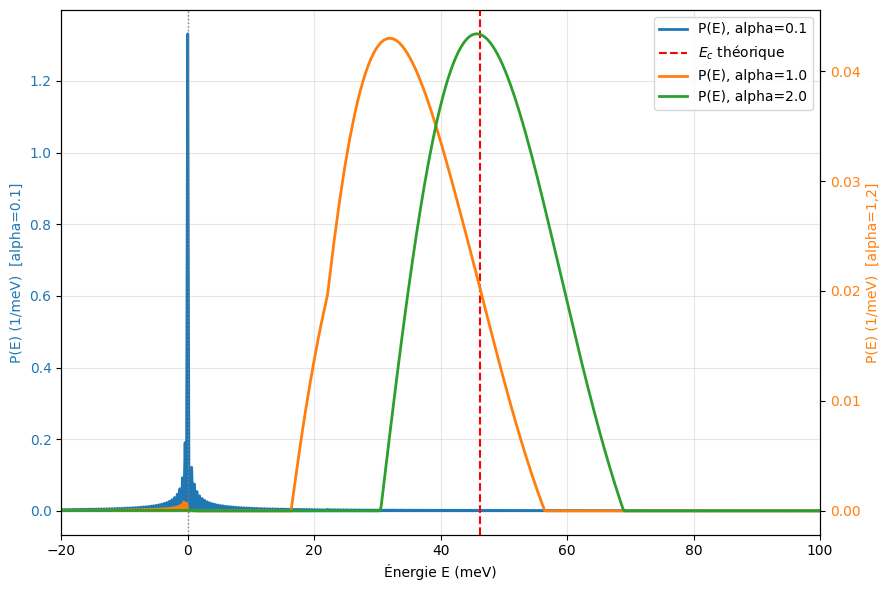

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.fft import fft, fftshift, fftfreq
import warnings

warnings.filterwarnings("ignore")

# =============================================================================
# 1. CONSTANTES PHYSIQUES
# =============================================================================
e_charge = 1.602176634e-19
h_planck = 6.62607015e-34
hbar = h_planck / (2 * np.pi)
k_boltz = 1.380649e-23
Rk = h_planck / (e_charge ** 2)

# =============================================================================
# 2. PARAMÈTRES DU SYSTÈME
# =============================================================================
C_el = 1.73e-18  # 1.73 aF
alpha  = 2            # alpha = R_env / Rk
R_el = alpha * Rk
T_el = 0.1  # 100 mK

# Paramètres temporels
t_max = 10e-12  # fenêtre totale ~ 5 ps
N_points = 2 ** 16  # points temporels
use_window = True  # True = applique une fenêtre de type Hann

# Paramètres d'intégration en fréquence pour J(t)
omega_c = 1.0 / (R_el * C_el)
omega_max = 3.0 * omega_c
n_omega = 20000


# =============================================================================
# 3. ENVIRONNEMENT RC : Re Z(ω)/Rk
# =============================================================================
def get_real_impedance_ratio(omega, R, C):
    """
    Re[Z_tot(omega)] / Rk pour un environnement RC série simple.
    Z(ω) = R / (1 + jωRC)  -> Re Z = R / (1 + (ωRC)^2)
    """
    omega = np.maximum(omega, 1e-16)
    denom = 1.0 + (omega * R * C) ** 2
    re_Z = R / denom
    return re_Z / Rk


# =============================================================================
# 4. CALCUL DE J(t)
# =============================================================================
def precompute_spectrum(R, C, T, omega_max=omega_max, n_omega=n_omega):
    """
    Pré-calcule les quantités dépendant seulement de ω pour J(t).
    """
    beta = 1.0 / (k_boltz * T)

    # Grille logarithmique en fréquence
    w = np.logspace(9, np.log10(omega_max), n_omega)
    dw = np.diff(w)
    w_mid = np.sqrt(w[:-1] * w[1:])  # points milieux
    dw_mid = dw  # même longueur

    rho = get_real_impedance_ratio(w_mid, R, C)

    x = 0.5 * beta * hbar * w_mid
    coth_term = np.ones_like(x)
    mask_low = x < 1e-5
    mask_mid = (x >= 1e-5) & (x < 200.0)
    coth_term[mask_low] = 1.0 / x[mask_low]
    coth_term[mask_mid] = 1.0 / np.tanh(x[mask_mid])

    # Facteur d'intégration complet
    prefactor = 9.5
    factor = (prefactor / np.pi) * rho * dw_mid / w_mid

    return factor, w_mid, coth_term


def compute_J_time_axis(R, C, T, t_max, N):
    """
    Calcule J(t) sur l’axe complet [-t_max, t_max[ par symétrisation.
    """
    # Axe temporel positif
    t_pos = np.linspace(0.0, t_max, N // 2, endpoint=False)

    factor, w, coth = precompute_spectrum(R, C, T)

    # J(t) = ∫ dω (...) -> forme discrète
    J_pos = np.zeros_like(t_pos, dtype=complex)

    chunk_size = 2000
    for i in range(0, len(t_pos), chunk_size):
        t_chunk = t_pos[i:i + chunk_size]
        wt = np.outer(w, t_chunk)
        cos_wt = np.cos(wt)
        sin_wt = np.sin(wt)

        # partie réelle : ∑ factor * coth * (cos(ωt) - 1)
        real_part = np.dot(factor * coth, cos_wt - 1.0)
        # partie imaginaire : - ∑ factor * sin(ωt)
        imag_part = -np.dot(factor, sin_wt)

        J_pos[i:i + chunk_size] = real_part + 1j * imag_part

    # print("Re J(t) début/fin :", J_pos[1].real, J_pos[-1].real)

    # Symétrisation : J(-t) = J*(t)
    J_neg = np.flip(np.conj(J_pos[1:]))
    J_total = np.concatenate((J_neg, J_pos))

    # Axe temps
    dt = t_pos[1] - t_pos[0]
    N_tot = len(J_total)
    t_axis = dt * (np.arange(-N_tot // 2, N_tot // 2))

    # Réordonne J(t) pour fftshift
    J_total = np.roll(J_total, -N_tot // 2)

    return t_axis, J_total, dt


# =============================================================================
# 5. CALCUL DE P(E)
# =============================================================================
def compute_P_of_E(R, C, T, t_max, N, window=True):
    """
    Calcule P(E) à partir de J(t) via FFT, avec normalisation correcte.
    """
    t_axis, J_t, dt = compute_J_time_axis(R, C, T, t_max, N)

    # Fonction de corrélation f(t) = exp(J(t))
    f_t = np.exp(J_t)

    # Fenêtre optionnelle (Hann)
    if window:
        win = np.hanning(len(f_t))
        f_t = f_t * win

    # FFT et passage à l'énergie
    F_w = fftshift(fft(f_t)) * dt

    freqs = fftshift(fftfreq(len(f_t), dt))  # Hz
    omegas = 2.0 * np.pi * freqs  # rad/s
    E_axis = -hbar * omegas  # Joules

    P_raw = np.real(F_w) / (2.0 * np.pi * hbar)

    P_raw[P_raw < 0] = 0.0
    # Tri en énergie croissante
    idx = np.argsort(E_axis)
    E_sorted = E_axis[idx]
    P_sorted = P_raw[idx]
    # Normalisation ∫P(E)dE = 1
    norm = trapezoid(P_sorted, E_sorted)
    if norm > 0:
        P_sorted /= norm

    return E_sorted, P_sorted


# =============================================================================
def compute_peak_and_fwhm(E, P):
    """
    E en Joules, P en 1/J.
    Retourne:
    - E_peak_meV : énergie du pic en meV
    - P_max_meV  : hauteur du pic en 1/meV
    - fwhm_meV   : largeur à mi-hauteur en meV
    """
    # Conversion en meV et 1/meV
    E_meV = E / e_charge * 1e3
    P_meV = P * e_charge / 1e3

    # Pic
    idx_max = np.argmax(P_meV)
    P_max = P_meV[idx_max]
    E_peak = E_meV[idx_max]

    # Niveau mi-hauteur
    half = P_max / 2.0

    # Côté gauche
    i_left = idx_max
    while i_left > 0 and P_meV[i_left] > half:
        i_left -= 1
    # interpolation linéaire
    E_left = np.interp(half,
                       [P_meV[i_left], P_meV[i_left + 1]],
                       [E_meV[i_left], E_meV[i_left + 1]])

    # Côté droit
    i_right = idx_max
    while i_right < len(P_meV) - 1 and P_meV[i_right] > half:
        i_right += 1
    E_right = np.interp(half,
                        [P_meV[i_right - 1], P_meV[i_right]],
                        [E_meV[i_right - 1], E_meV[i_right]])

    fwhm = E_right - E_left

    return E_peak, P_max, fwhm


# ================================================================

# =============================================================================
# 6. TEST & PLOT AVEC DEUX AXES Y
# =============================================================================
if __name__ == "__main__":
    # ===================================================================
    Ec_joule = e_charge ** 2 / (2.0 * C_el)
    Ec_meV = Ec_joule / e_charge * 1e3

    alphas = [0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
    print(f"C = {C_el:.2e} F, T = {T_el} Kelvin,t_max = {t_max:.3e} s, N = {N_points}, fenêtre = {use_window}")
    print("alpha | E_peak(meV) | P_max(1/meV) | FWHM(meV) | 1/2*P_max*FWHM | Incertitude(%)")
    print("----------------------------------------------------------------------------------")

    for alpha in alphas:
        R_el = alpha * Rk
        omega_c = 1.0 / (R_el * C_el)
        omega_max = 3.0 * omega_c

        E, P = compute_P_of_E(R_el, C_el, T_el, t_max, N_points, window=use_window)
        E_peak_meV, P_max_meV, fwhm_meV = compute_peak_and_fwhm(E, P)
        prod = 0.5 * P_max_meV * fwhm_meV

        print(f"{alpha:4.2f} | {E_peak_meV:10.2f} | {P_max_meV:11.4f} |"
              f" {fwhm_meV:9.2f} | {prod:10.3f}  |{fwhm_meV/E_peak_meV*100:10.1f} ")


    # --------- Calcul pour alpha = 0.1 ---------
    alpha = 0.1
    R_el = alpha * Rk
    omega_c = 1.0 / (R_el * C_el)
    omega_max = 3.0 * omega_c

    print("=== Calcul Energie de Charge Ec ===")
    #============================================
    E_01, P_01 = compute_P_of_E(R_el, C_el, T_el, t_max, N_points, window=use_window)
    E_01_meV = E_01 / e_charge * 1e3
    P_01_meV = P_01 * e_charge / 1e3
    # ============================================
    Ec_joule = e_charge ** 2 / (2.0 * C_el)
    Ec_meV = Ec_joule / e_charge * 1e3

    # Pic de P(E)
    idx_max = np.argmax(P_01)
    E_peak_meV = E[idx_max] / e_charge * 1e3
    print("Ec Théorique(meV) | E_peak(meV) | Ratio (Pic/Etheo) | Alpha | R(KOhm) | Incertitude(%)")
    print("-----------------------------------------------------------------------------------------")
    print(f"{Ec_meV:10.2f} | {E_peak_meV:15.2f} | {E_peak_meV / Ec_meV:15.3f} | {alpha:10.2f} | {R_el*1e-3:5.2f} | {fwhm_meV/E_peak_meV*100:10.1f} ")

    # ============================================
    # --------- Calcul pour alpha = 1 et 2 ---------
    alphas = [1.0, 2.0]
    colors = ['tab:orange', 'tab:green']
    EP_list = []

    for alpha_val, col in zip(alphas, colors):
        alpha = alpha_val
        R_el = alpha * Rk
        omega_c = 1.0 / (R_el * C_el)
        omega_max = 3.0 * omega_c


        E, P = compute_P_of_E(R_el, C_el, T_el, t_max, N_points, window=use_window)
        E_meV = E / e_charge * 1e3
        P_meV = P * e_charge / 1e3

        EP_list.append((E_meV, P_meV, alpha_val, col))

        # ============================================
        Ec_joule = e_charge ** 2 / (2.0 * C_el)
        Ec_meV = Ec_joule / e_charge * 1e3

        # Pic de P(E)
        idx_max = np.argmax(P)
        E_peak_meV = E[idx_max] / e_charge * 1e3

        print(
            f"{Ec_meV:10.2f} | {E_peak_meV:15.2f} | {E_peak_meV / Ec_meV:15.3f} | {alpha:10.2f} | {R_el * 1e-3:5.2f} | {fwhm_meV/E_peak_meV*100:10.1f} ")
        # ============================================

    # --------- Figure avec deux axes Y ---------
    fig, ax_left = plt.subplots(figsize=(9, 6))

    # Axe de gauche : alpha = 0.1
    ax_left.plot(E_01_meV, P_01_meV, lw=2, color='tab:blue',
                 label="P(E), alpha=0.1")
    ax_left.set_xlabel("Énergie E (meV)")
    ax_left.set_ylabel("P(E) (1/meV)  [alpha=0.1]", color='tab:blue')
    ax_left.tick_params(axis='y', labelcolor='tab:blue')
    ax_left.set_xlim(-20, 100)
    ax_left.grid(True, alpha=0.3)

    # Lignes verticales communes
    ax_left.axvline(Ec_meV, color='r', ls='--', lw=1.5, label=r"$E_c$ théorique")
    ax_left.axvline(0.0, color='gray', ls=':', lw=1.0)

    # Axe de droite : alpha = 1 et 2
    ax_right = ax_left.twinx()
    for E_meV, P_meV, alpha_val, col in EP_list:
        ax_right.plot(E_meV, P_meV, lw=2, color=col,
                      label=f"P(E), alpha={alpha_val}")
    ax_right.set_ylabel("P(E) (1/meV)  [alpha=1,2]", color='tab:orange')
    ax_right.tick_params(axis='y', labelcolor='tab:orange')

    # Gestion des légendes (combiner les deux axes)
    lines_left, labels_left = ax_left.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_left + lines_right,
                   labels_left + labels_right,
                   loc="upper right")

    fig.tight_layout()
    plt.show()





